In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the Neural Network Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(28*28, 512)  # 28*28 is the size of MNIST images
        # Second fully connected layer
        self.fc2 = nn.Linear(512, 256)
        # Third fully connected layer that outputs 10 classes
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Flatten the image from [28x28] to [784]
        x = x.view(-1, 28*28)
        # Apply ReLU activation function after each fully connected layer, except the last one
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Apply softmax on the output of the last layer to get the probability distribution over 10 classes
        return F.log_softmax(x, dim=1)

# Create an instance of the Net
model = Net()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing the images
])

# Loading MNIST dataset from torchvision.dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


In [7]:
import csv
import matplotlib.pyplot as plt
# Initialize CSV file for logging
csv_file = "training_logs.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'])

In [8]:
import torch.optim as optim
from tqdm import tqdm
# Training Function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    print('Train Epoch: {} \tLoss: {:.6f}, Accuracy: {:.2f}%'.format(epoch, train_loss, 100. * correct / len(train_loader.dataset)))
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

# Evaluation Function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * correct / len(test_loader.dataset)))
    test_accuracy= 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Testing the model
for epoch in tqdm(range(1, 5)):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    # Write to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, train_loss, train_accuracy, test_loss, test_accuracy])


  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.003144, Accuracy: 93.81%


 25%|██▌       | 1/4 [01:09<03:29, 69.82s/it]

Test set: Average loss: 0.0960, Accuracy: 97.10%

Train Epoch: 2 	Loss: 0.001322, Accuracy: 97.31%


 50%|█████     | 2/4 [02:17<02:16, 68.39s/it]

Test set: Average loss: 0.0846, Accuracy: 97.42%

Train Epoch: 3 	Loss: 0.000914, Accuracy: 98.12%


 75%|███████▌  | 3/4 [03:26<01:08, 68.93s/it]

Test set: Average loss: 0.0738, Accuracy: 97.71%

Train Epoch: 4 	Loss: 0.000713, Accuracy: 98.62%


100%|██████████| 4/4 [04:35<00:00, 68.91s/it]

Test set: Average loss: 0.1191, Accuracy: 96.56%



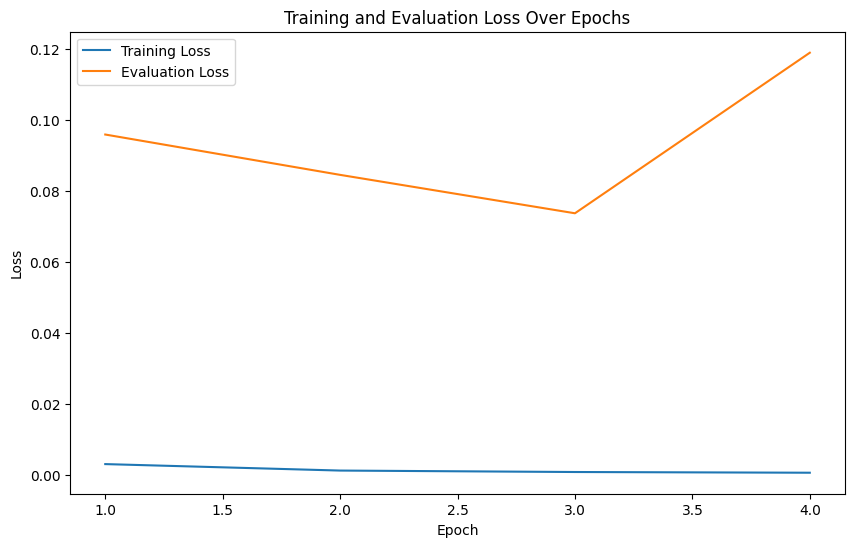

In [9]:
import pandas as pd

# Load the logs into a DataFrame
logs = pd.read_csv(csv_file)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(logs['Epoch'], logs['Training Loss'], label='Training Loss')
plt.plot(logs['Epoch'], logs['Test Loss'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.show()
